# Import Data and Train Model


In [1]:
%load_ext tensorboard
import tensorflow as tf
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda

import os
import numpy as np
import scipy
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
import IPython.display

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math
from PIL import Image
from IPython.display import display

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import mne
import mne.channels

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load Data: Create Dataset


### Load Absence Seizure Data


In [2]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            x_loaded.append(np.load(row["data"]))
            y_loaded.append(np.load(row["labels"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [3]:
# Load the dataset

dataset = AbsenceDataset(
    "processed_data/absence/five_channels_improved_labels/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)

len(dataset)

4141

# MFCC


Select a random label


In [4]:
c = 0
for i, v in enumerate(dataset.y):
    if v == "1":
        data_test = dataset.x[i]
        if c == 15:
            break
        c += 1

data_test = dataset.x[0]

Convert epochs to FFT


In [5]:
%%capture
def convert_fft(dataset_x):
    fft_data = []
    for i, v in enumerate(dataset_x):

        info = mne.create_info(ch_names=["1", "2", "3", "4", "5"], sfreq=250, ch_types="eeg")
        raw = mne.io.RawArray(v, info)
        raw = mne.channels.combine_channels(raw, groups=dict(r=[0, 1, 2, 3, 4]), method="mean")

        sample_rate = 250
        yf = fft(v[0])

        fft_data.append(yf)
    
    return fft_data

In [7]:
fft_data = np.array(convert_fft(dataset.x))
fft_data.shape

(4141, 1000)

Create Filter Bank


In [86]:
sample_rate = 250
freq_min = 0
freq_high = sample_rate / 2
mel_filter_num = 15

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))
fft_size = 512

Minimum frequency: 0
Maximum frequency: 125.0


In [87]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)


def met_to_freq(mels):
    return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

In [92]:
# Get freq points where mel filters will be applied
def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)

    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))

    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num + 2)
    freqs = met_to_freq(mels)

    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

In [93]:
filter_points, mel_freqs = get_filter_points(
    freq_min, freq_high, mel_filter_num, fft_size, sample_rate=250
)
filter_points

MEL min: 0.0
MEL max: 185.16858265005916


array([  0,  14,  29,  44,  60,  75,  91, 107, 122, 139, 155, 171, 188,
       205, 222, 239, 256])

In [97]:
# Get filters that will be applied
def get_filters(filter_points, FFT_size):
    # amplify lower filters
    filters = np.zeros((len(filter_points) - 2, int(FFT_size / 2 + 1)))

    for n in range(len(filter_points) - 2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(
            0, 1, filter_points[n + 1] - filter_points[n]
        )
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(
            1, 0, filter_points[n + 2] - filter_points[n + 1]
        )

    return filters

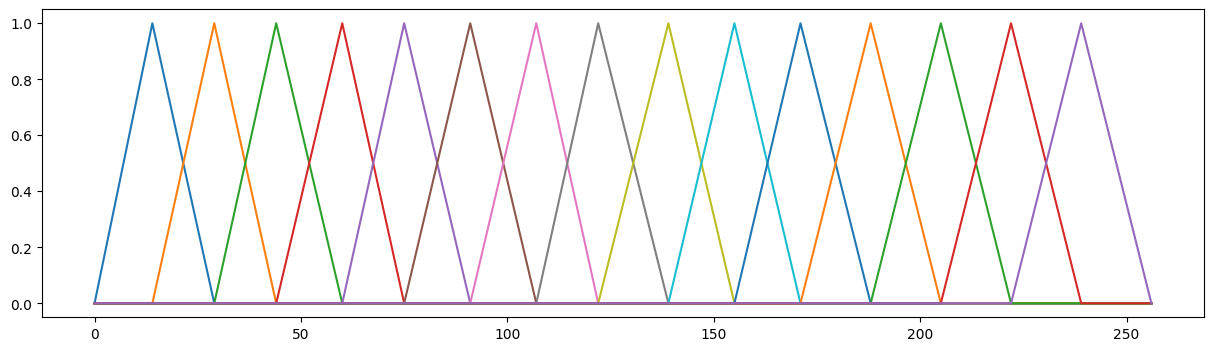

In [96]:
filters = get_filters(filter_points, fft_size)

plt.figure(figsize=(15, 4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [98]:
enorm = 2.0 / (mel_freqs[2 : mel_filter_num + 2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

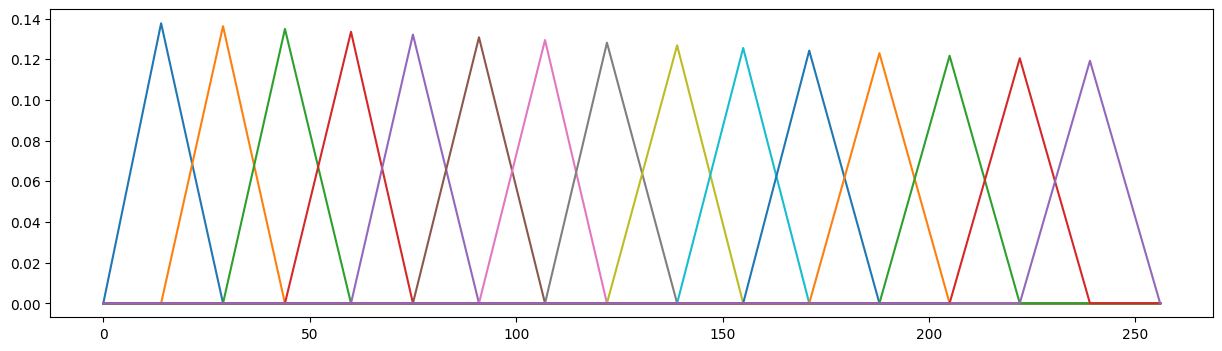

In [99]:
plt.figure(figsize=(15, 4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

# Split Data

70%, 20%, 10%


In [203]:
if (int(len(dataset) * 0.7) + int(len(dataset) * 0.2) + int(len(dataset) * 0.1)) != len(
    dataset
):
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(len(dataset) * 0.7),
            int(len(dataset) * 0.2),
            int(len(dataset) * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [int(len(dataset) * 0.7), int(len(dataset) * 0.2), int(len(dataset) * 0.1)],
    )

train_set.dataset.x[train_set.indices].shape, eval_set.dataset.x[
    train_set.indices
].shape, test_set.dataset.x[train_set.indices].shape

((2899, 5, 1000), (2899, 5, 1000), (2899, 5, 1000))

In [204]:
x_train_reshaped = train_set.dataset.x[train_set.indices]
x_train_reshaped = x_train_reshaped.reshape(2899, -1)

x_train_reshaped.shape

(2899, 5000)

# Visualize Data


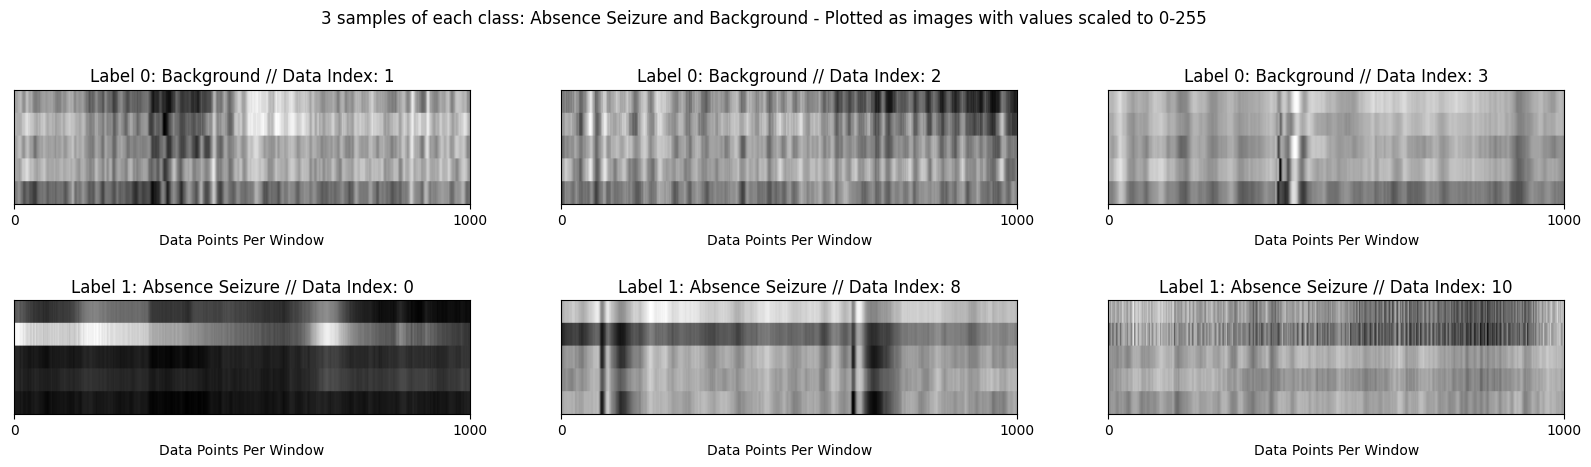

In [102]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
fig.suptitle(
    "3 samples of each class: Absence Seizure and Background - Plotted as images with values scaled to 0-255"
)

c1 = 0
c0 = 0

for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 0 and c0 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0
        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[0, c0].imshow(clone, cmap="gray")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        axs[0, c0].set_yticks([])
        axs[0, c0].set_xticks([0, 1000])
        axs[0, c0].set_xlabel("Data Points Per Window")

        c0 += 1

    if v == 1 and c1 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[1, c1].imshow(clone, cmap="gray")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        axs[1, c1].set_yticks([])
        axs[1, c1].set_xticks([0, 1000])
        axs[1, c1].set_xlabel("Data Points Per Window")

        c1 += 1

    if c1 == 3 and c0 == 3:
        break

    # new_img = Image.fromarray(clone)

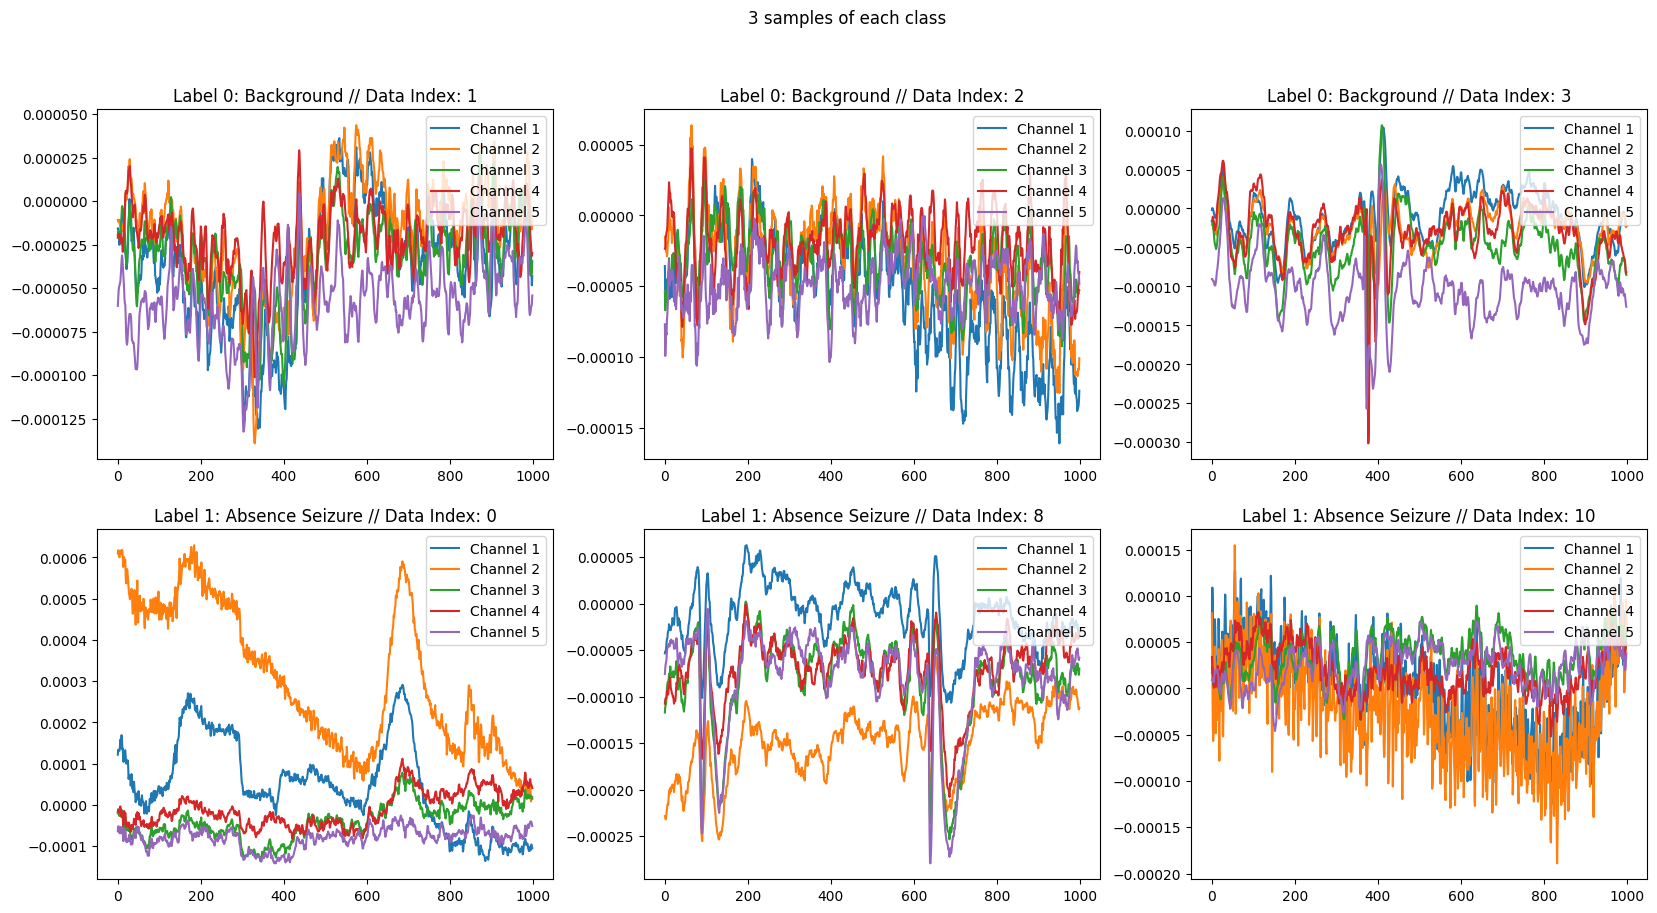

In [114]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(train_set.dataset.x[train_set.indices]):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[0, c0].legend(loc="upper right")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[1, c1].legend(loc="upper right")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

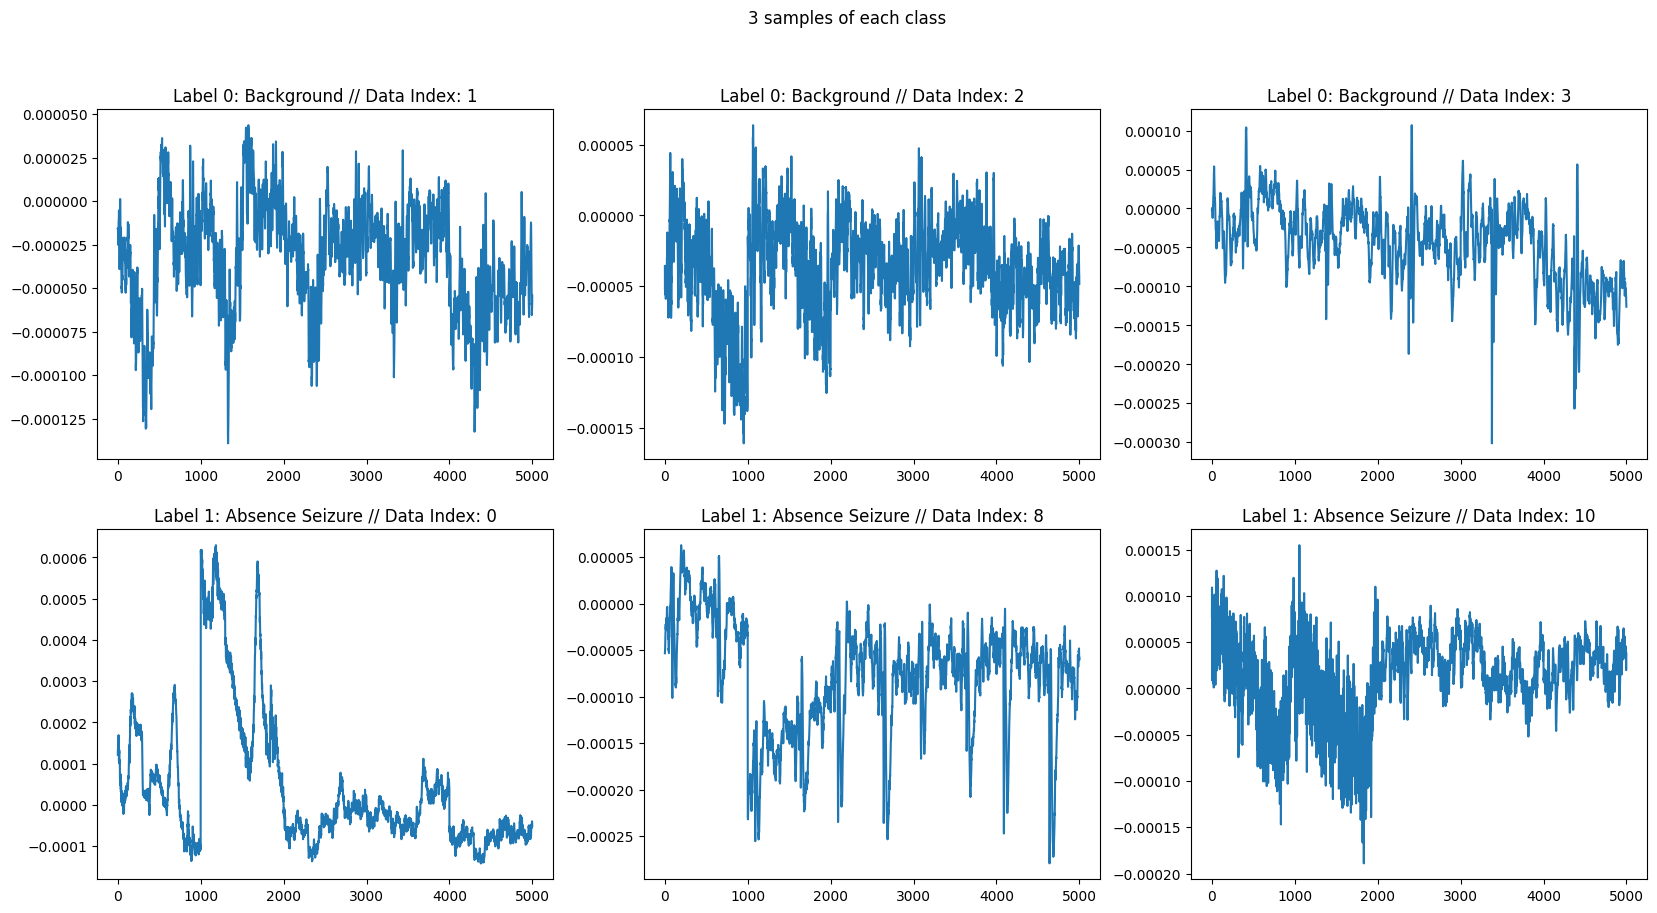

In [110]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(x_train_reshaped):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(x_train_reshaped[i])
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(x_train_reshaped[i])
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

# Smote


## Smote on 1 Channel Data


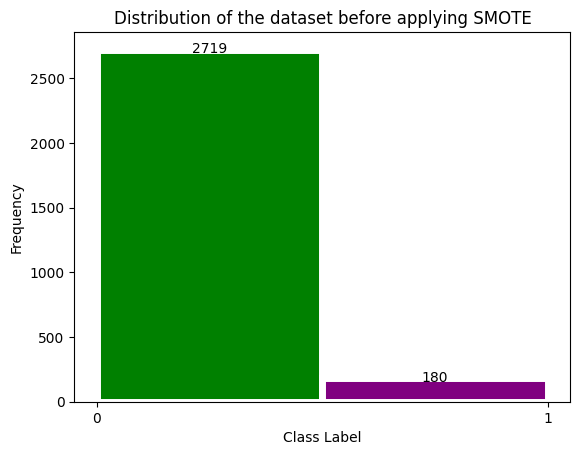

In [291]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in train_set.dataset.y[train_set.indices]:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

In [293]:
x_train, y_train = SMOTE(sampling_strategy="minority", random_state=42).fit_resample(
    x_train_reshaped, train_set.dataset.y[train_set.indices]
)

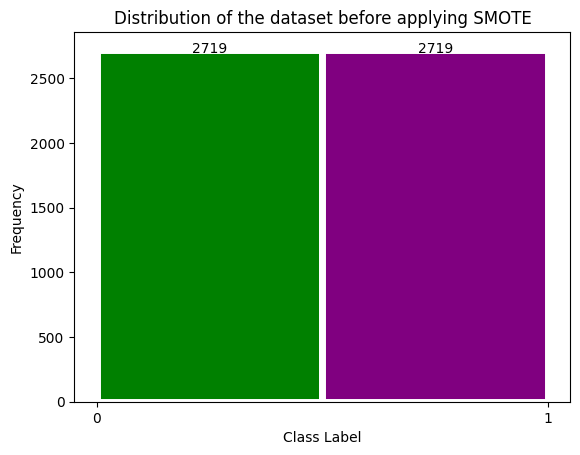

In [294]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in y_train:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

## Smote on Multi Channel Data


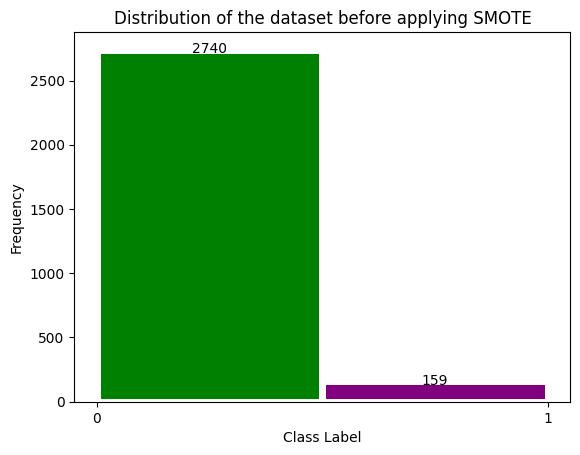

In [205]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in train_set.dataset.y[train_set.indices]:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

In [206]:
print(x_train_reshaped[0].shape)

# Apply Smote
x_train, y_train = SMOTE(sampling_strategy="minority", random_state=42).fit_resample(
    x_train_reshaped, train_set.dataset.y[train_set.indices]
)

print(len(x_train))
# Reshape Data
x_train = x_train.reshape(x_train.shape[0], 5, 1000)

print(x_train.shape)

(5000,)
5480
(5480, 5, 1000)


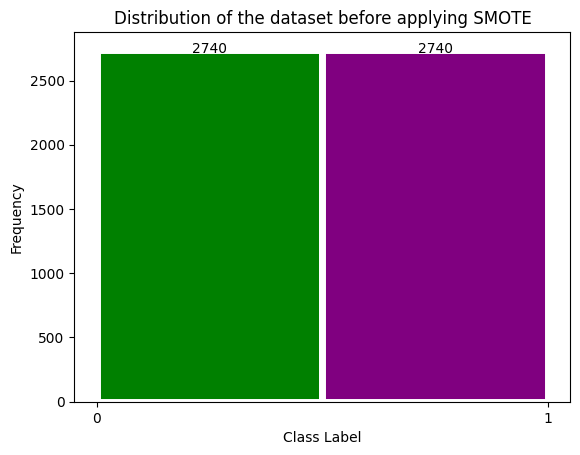

In [207]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

l = []
for i in y_train:
    l.append(i)

a1, b1, bars = plt.hist(l, bins=2, edgecolor="white", linewidth=5, range=(0, 1))
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title("Distribution of the dataset before applying SMOTE")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
bars[0].set_facecolor("green")
bars[1].set_facecolor("purple")
# put count
for i in bars:
    plt.text(
        i.get_x() + i.get_width() / 2,
        i.get_height() - 50,
        int(i.get_height()),
        ha="center",
        va="bottom",
    )
plt.show()

# DataLoaders


In [208]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [209]:
new_balanced_train_dataset = BalancedDataset(
    (x_train, y_train), transform=torch.tensor, target_transform=torch.tensor
)

In [263]:
train_dataloader = DataLoader(
    dataset=new_balanced_train_dataset, batch_size=5, shuffle=True
)
eval_dataloader = DataLoader(dataset=eval_set, batch_size=5, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

# Model


## 1D Model


In [231]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=1, out_channels=256, kernel_size=10)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=256, out_channels=512, kernel_size=10)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=512, out_channels=1024, kernel_size=10)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(119808, 1024)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)

Number of parameters in model: 130,292,993


## 2D Model


In [249]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv2d(
            in_channels=1, out_channels=17, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=2)

        self.CNN2 = nn.Conv2d(
            in_channels=17, out_channels=29, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool2 = nn.MaxPool2d(kernel_size=(2, 2), stride=2)

        self.CNN3 = nn.Conv2d(
            in_channels=29, out_channels=41, kernel_size=(3, 3), padding=(1, 0)
        )
        self.MaxPool3 = nn.MaxPool2d(kernel_size=(1, 1), stride=2)

        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(5043, 1024)
        self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        x = self.output(x)
        return x


# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Print Model
model = model.to(device)
model

Number of parameters in model: 6,231,059


AbnormalNeuralNetwork(
  (CNN1): Conv2d(1, 17, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool1): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv2d(17, 29, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv2d(29, 41, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool3): MaxPool2d(kernel_size=(1, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5043, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (output): Linear(in_features=1024, out_features=1, bias=True)
)

# Train


## Train Function


In [270]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.0
    last_loss = 0.0
    counter = 0

    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)

        outputs = outputs.squeeze(-1)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if counter == 100:
            last_loss = running_loss / 100  # loss per batch
            print("  batch {} loss: {}".format(i + 1, last_loss))
            tb_x = epoch_index * len(train_dataloader) + i + 1
            tb_writer.add_scalar("Loss/train", last_loss, tb_x)
            running_loss = 0.0
            counter = 0

        counter += 1

    return last_loss

## Training Loop


In [271]:
EPOCHS = 500  # Number of training iterations
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
writer = SummaryWriter("runs/m1{}".format(timestamp))
epoch_number = 0

best_vloss = 1_000_000.0

loss_track_train = []
loss_track_valid = []

for i in range(EPOCHS):
    print(f"EPOCH {i+1}")

    model.train(True)
    avg_loss = train_one_epoch(i, writer)

    running_vloss = 0.0
    model.eval()

    with torch.no_grad():
        for i, data in enumerate(eval_dataloader):
            vinputs, vlabels = data
            vinputs, vlabels = vinputs.to(device), vlabels.to(device)
            vinputs = vinputs.unsqueeze(1)
            # print(vinputs.shape)
            voutputs = model(vinputs).to(device)
            voutputs = voutputs.squeeze(-1)
            vloss = loss_fn(voutputs, vlabels)
            running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    print("LOSS train {} valid {}".format(avg_loss, avg_vloss))

    loss_track_train.append(avg_loss)
    loss_track_valid.append(avg_vloss)

    writer.add_scalars(
        "Training vs. Validation Loss",
        {"Training": avg_loss, "Validation": avg_vloss},
        epoch_number + 1,
    )
    writer.flush()

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = "model_{}_{}".format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1
  batch 101 loss: 0.49966498964349737
  batch 201 loss: 0.5204585614291136
  batch 301 loss: 0.49725700518349186
  batch 401 loss: 0.5560259525477886
  batch 501 loss: 0.5095719654677668
  batch 601 loss: 0.5540354946185835
  batch 701 loss: 0.5238886870018905
  batch 801 loss: 0.5515434204321354
  batch 901 loss: 0.5223221886527608
  batch 1001 loss: 0.5202408115024446
LOSS train 0.5202408115024446 valid 0.05242171198240459
EPOCH 2
  batch 101 loss: 0.5680855003700708
  batch 201 loss: 0.5329633895860753
  batch 301 loss: 0.4989803524743184
  batch 401 loss: 0.5293716317694634
  batch 501 loss: 0.49067206076695585
  batch 601 loss: 0.5095385471411282
  batch 701 loss: 0.520291184335947
  batch 801 loss: 0.566750999672222
  batch 901 loss: 0.5208516289008549
  batch 1001 loss: 0.5142200872840477
LOSS train 0.5142200872840477 valid 0.052421711757638864
EPOCH 3
  batch 101 loss: 0.49517541676963445
  batch 201 loss: 0.5476199402770726
  batch 301 loss: 0.5497269035526551
  batch 

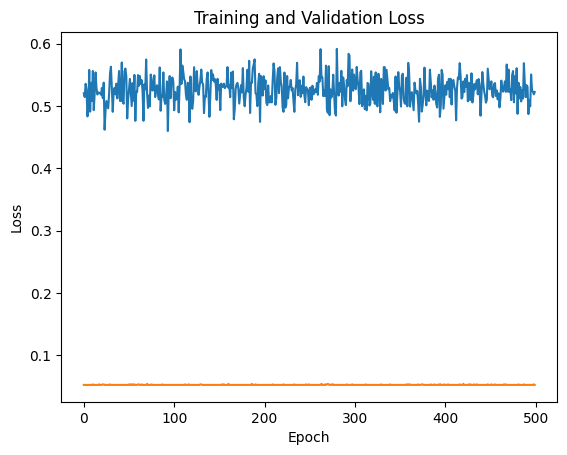

In [273]:
# Plot losses
plt.plot(range(len(loss_track_train)), loss_track_train, label="Training Loss")
plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")


plt.title("Training and Validation Loss")

plt.xlabel("Epoch")

plt.ylabel("Loss")


plt.show()